In [1]:

import numpy as np 
from keras.datasets import mnist
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [2]:
class Conv1D:
    def __init__(self, f_size, initializer, optimizer, p =1, stride=1, n_channel_in = 1, n_channel_out= 1):
        self.init = initializer
        self.optimizer = optimizer
        self.n_channel_in = n_channel_in
        self.n_channel_out = n_channel_out
        self.stride = stride
        self.pad = p
        self.n_out = None
        self.f_size = f_size
    
    def forward(self, X):
        self.n_in = X.reshape(-1, 1).shape[0] # number of features
        self.n_samples = X.reshape(-1, 1).shape[1] # number of samples

        self.x_new = X.reshape(self.n_channel_in, self.n_samples, self.n_in) # reshape into 3D array of (layers, number of samples, number of features)
        self.x_new = np.pad(self.x_new, ((0, 0), (0, 0), (self.pad, self.pad))) # Adds padding around row and column for each layer
        
        self.n_out = num_out(self.n_in, self.pad, self.f_size, self.stride) # calculates the number of output from this convolutional layer
        
        output = np.zeros((self.n_channel_in, self.n_samples, self.n_out)) # features

        # initialization of weights and biases
        self.w = self.init.W((self.n_channel_in, self.n_samples, self.f_size))
        self.b = self.init.B((self.n_channel_in, self.n_samples, self.f_size))
        

        # Loops through each layer, convolutes the rows and columns for each, and performs forward propagation
        for i in range(self.n_channel_in):
            a = np.array([]) # features extracted by filter
            for j in range(0, self.x_new.shape[-1], self.stride):
                if j + self.f_size > self.x_new.shape[-1] :
                    break
                
                a = np.append(a, np.sum(self.x_new[i][:, j: j + self.f_size][0] @ self.w[i][0] + self.b[i][0]))
     
            output[i] = a
            #a = np.array(a).reshape(1, 1, a.shape[-1]) # reshape into (1, 1, number of features)
            #output = np.append(output, a, axis=0) # appended extracted features to layer

        return output.sum(axis=0)

    
    def backward(self, dA):
        self.dB = np.sum(dA, axis=(0, -1), dtype=np.float64)
        n_in = self.x_new.shape[-1] # number of input features
        self.dW = np.zeros((self.n_channel_in, self.n_samples, self.f_size))
        
        
        
        l = dA.shape[-1]
        for i in range(self.n_channel_in):
            layer = self.x_new[i]
            w = np.array([])
            for j in range(0, n_in, self.stride):
                if j + l > n_in:
                    break           
                w = np.append(w, dA[i] @ layer[:, j: j + l][0])        
            self.dW[i] = w
      
        self.dx = np.zeros((self.n_channel_in, 1, self.f_size))

        a = np.pad(dA, ((0, 0), (0, 0), (self.pad, self.pad)))
        dx = np.ones((self.n_channel_in, dA.shape[1], self.n_out))

        for  i in range(self.n_channel_in):
            layer = a[i]
            weight = self.w[i]
            w = np.array([])
            for j in range(0, a.shape[-1], self.stride):
                if j + self.f_size > a.shape[-1]:
                    break
                w = np.append(w, layer[:, j: j+self.f_size][0] @ weight[0])
            dx[i] = w
        self.optimizer.update(self)
        return dx
            

def num_out(n_in, pad, f, s):
    """
    ##### self.n_in: number of features
    ##### pad: Number of padding on one side
    ##### s: stride value

    ##### Returns: Number of output of convolution
    """
    n_out = ((n_in + 2*pad - f)/ s) +1
    return int(n_out)

In [3]:
class FC:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer: instance of initialization method
    optimizer: instance of optimization method
    """
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.w = initializer.W((n_nodes1, n_nodes2))
        self.b = initializer.B((n_nodes2,))
        

        
    
    def forward(self, X):
        """
        forward
        Parameters
        ----------
        X : The following forms of ndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : The following forms of ndarray, shape (batch_size, n_nodes2)
            output
        """        
        self.Z = X
        A = X @ self.w + self.b
        
        return A
    
    def backward(self, dA):
        """
        Backward
        Parameters
        ----------
        dA : The following forms of ndarray, shape (batch_size, n_nodes2)
            Gradient flowing from behind
        Returns
        ----------
        dZ : The following forms of ndarray, shape (batch_size, n_nodes1)
            Gradient to flow forward
        """
        
        # update
        self.dB = np.sum(dA, axis=0)

       # print(self.dB)
        self.dW = self.Z.T @ dA 
        self.dZ = dA @ self.w.T
        
        self.optimizer.update(self)
        
        return self.dZ

In [4]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, shape):
        """
        Weight initialization
        Parameters
        ----------
        Shape: tuple
        Returns
        ----------
        W :
        """
        w = self.sigma * np.random.randn(*shape)
        
        return w
    
    def B(self, shape):
        """
        Bias initialization
        Parameters
        ----------
        shape : tuple
          Number of nodes in the later layer

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(*shape)
        return B


In [5]:
class Relu:
    def __init__(self) -> None:
        pass

    def forward(self, X):
        self.A = X
        return np.clip(X, 0, None)
    
    def backward(self, X):
        a = X > 0
        return X * np.clip(np.sign(self.A), 0, None)

class Tanh:
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

class Softmax():
        def __init__(self) -> None:
            pass


        def forward(self, a):
            numerator = np.exp(a)
            self.dZ = numerator / np.sum(np.exp(a), axis=1).reshape(-1, 1)
            return self.dZ
        
        def backward(self, Y):
             self.loss = self.loss_func(Y)   
                      
             return self.dZ - Y
        
        def loss_func(self, Y, Z = None):             
            if type(Z) == type(None):
                Z = self.dZ

            loss = -1* np.sum(Y * np.log(Z + 1e-7))

            return loss/len(Y)

            
            
        
    

In [6]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr 
        self.HW = 1
        self.HB = 1

    def update(self, layer):

        self.HW += layer.dW**2
        self.HB += layer.dB**2

        layer.w -= self.lr * np.sqrt(1/self.HW) * (layer.dW)
        layer.b -= self.lr * np.sqrt(1/self.HB) *  layer.dB


class SGD:
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        The weight or bias of a certain layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """

        layer.w -= self.lr * layer.dW
        layer.b -= self.lr * layer.dB

In [7]:

class GetMiniBatch:
    """
Iterator to get a mini-batch

    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int_)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [8]:
class SratchConvolutionalNeuralNetwork1D:
    def __init__(self, epoch=10, lr=0.01, batch_size=20, padding =1, n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, filter_size = 3, verbose=True, initilizer = SimpleInitializer, Optimizer= AdaGrad, Activater = Tanh):
        self.epoch = epoch
        self.p = padding
        self.lr = lr
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.f_size = filter_size
        self.verbose = verbose
        self.optimizer = Optimizer
        self.init = initilizer(0.05)
        self.activater = Activater

  


    def fit(self, X, y, x_val = None, y_val= None):

        # neural network layers
        self.CN1 = Conv1D(self.f_size,self.init, self.optimizer(self.lr), p=self.p) 
        self.CN1.n_out = num_out(X.shape[-1], self.CN1.f_size, self.CN1.pad, self.CN1.stride)
        
        self.activater1 = self.activater()
        # fully connected layers
        self.FC2 = FC(self.n_features, self.n_nodes2, self.init, self.optimizer(self.lr))
        self.activater2 = self.activater()

        self.FC3 = FC(self.n_nodes2, self.n_output, self.init, self.optimizer(self.lr))

        # output layer
        self.FC3 = FC(self.n_nodes2, self.n_output, self.init, self.optimizer(self.lr))
        self.activater3 = Softmax()


        self.loss = []
        self.loss_epoch = [self.activater3.loss_func(y, self._forward(X))]

        for _ in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)

            for mini_x_train, mini_y_train in get_mini_batch:
                # forward propagation
                self._forward(mini_x_train)
                #backward 
                self._backward(mini_y_train)
                self.loss.append(self.activater3.loss)

            self.loss_epoch.append(self.activater3.loss_func(y, self._forward(X)))

            if self.verbose:
                print(f"({_}) : {self.loss_epoch}")
                
            
                        
        return self

    def _forward(self, X):
        # first hidden layer

        A1 = self.CN1.forward(X)    
        A1 = A1.reshape(-1, self.n_features)

        Z1 = self.activater1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activater2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activater3.forward(A3)

        return Z3

    def _backward(self, y):
        # Output layer
        dA3 = self.activater3.backward(y) 
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activater2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activater1.backward(dZ1)

        dA1 = dA1.flatten()
        dA1 = dA1[np.newaxis, np.newaxis,:]
        dZ0 = self.CN1.backward(dA1) 
        

        

In [9]:

#Data prep
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784)

x_test = x_test.reshape(-1, 784)

x_train, x_test = x_train.astype(np.float_), x_test.astype(np.float_)

x_train /= 255
x_test /= 255

print(x_train.max())
print(x_test.min())

1.0
0.0


In [10]:
onv = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

one_hot_y_train = onv.fit_transform(y_train[:, np.newaxis])
one_hot_y_test = onv.fit_transform(y_test[:, np.newaxis])

print(one_hot_y_test.shape)
print(one_hot_y_train.shape)

(10000, 10)
(60000, 10)


In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_train, one_hot_y_train, test_size=0.2)

print(x_train.shape)
print(x_val.shape)

(48000, 784)
(12000, 784)


In [12]:
x_train = x_train[:300]
y_train = y_train[:300]

print(x_train.shape)
print(y_train.shape)

(300, 784)
(300, 10)


In [13]:
model = SratchConvolutionalNeuralNetwork1D(epoch=10, batch_size=20, padding=1, filter_size=3, lr=0.001, verbose=True, Activater=Tanh)
model.fit(x_train, y_train)

(0) : [2.3145085283131923, 2.321801934425242]
(1) : [2.3145085283131923, 2.321801934425242, 2.319536706358327]
(2) : [2.3145085283131923, 2.321801934425242, 2.319536706358327, 2.3180271764332483]
(3) : [2.3145085283131923, 2.321801934425242, 2.319536706358327, 2.3180271764332483, 2.31701063203254]
(4) : [2.3145085283131923, 2.321801934425242, 2.319536706358327, 2.3180271764332483, 2.31701063203254, 2.316347742251077]
(5) : [2.3145085283131923, 2.321801934425242, 2.319536706358327, 2.3180271764332483, 2.31701063203254, 2.316347742251077, 2.315952190273227]
(6) : [2.3145085283131923, 2.321801934425242, 2.319536706358327, 2.3180271764332483, 2.31701063203254, 2.316347742251077, 2.315952190273227, 2.315765550658]
(7) : [2.3145085283131923, 2.321801934425242, 2.319536706358327, 2.3180271764332483, 2.31701063203254, 2.316347742251077, 2.315952190273227, 2.315765550658, 2.3157459346027394]
(8) : [2.3145085283131923, 2.321801934425242, 2.319536706358327, 2.3180271764332483, 2.31701063203254, 2

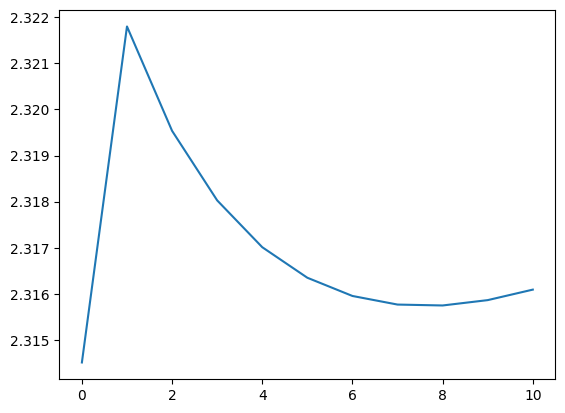

In [14]:
plt.plot(model.loss_epoch)

In [15]:
model = Conv1D(10, SimpleInitializer(0.01), AdaGrad(0.01))

print(model.forward(x_train).shape)

(1, 235193)
